# Árboles, ensambles



```R
# Paquetes para esta notebook (agreguen los que necesiten!)
packages <- c('ISLR2', 'randomForest', 'caTools', 'tree', 'glmnet', 'gbm')

# Instalamos los paquetes que no vienen por defecto en Colab
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Cargamos los paquetes sin verPackages loading
invisible(lapply(packages, library, character.only = TRUE))
```

In [46]:
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# from scipy.stats import uniform, norm
from sklearn.metrics import mean_squared_error as mse

# Ejercicio 1
*   Dataset: **Boston**
*   Lab 8.3.2 y 8.3.3, página 356
*   Ejercicio 8.4.7, página 363

1.   Realizar modelos de árbol de regresión, bagging y random forest para el dataset **Boston**. Comparar los errores en test. ¿Qué rol cumple el parámetro *mtry*? (seguir el desarrollo de los labs)
2.   Crear un gráfico que muestre el error en test para los modelos de random forest para un rango de valores de *mtry* y *ntree*.
3.   Interpretar y dar conclusiones.

In [124]:
boston = pd.read_csv("boston.csv")

In [3]:
from sklearn import tree
from sklearn.model_selection import train_test_split

In [4]:
X = boston.drop(columns="medv")
y = boston.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=X.shape[0] // 2)

In [5]:
t = tree.DecisionTreeRegressor(max_leaf_nodes=7).fit(X_train, y_train)
# t = tree.DecisionTreeRegressor().fit(X_train, y_train)

/home/gonzalo/miniconda3/envs/aag2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

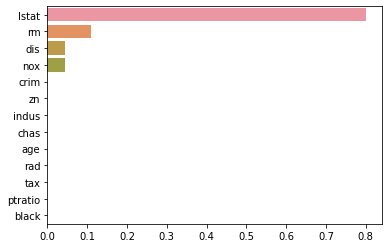

In [6]:
fi = pd.Series(t.feature_importances_, X.columns).sort_values(ascending=False)
sns.barplot(fi, fi.index)

In [7]:
pd.Series(range(X.shape[1]), X.columns)

crim        0
zn          1
indus       2
chas        3
nox         4
rm          5
age         6
dis         7
rad         8
tax         9
ptratio    10
black      11
lstat      12
dtype: int64

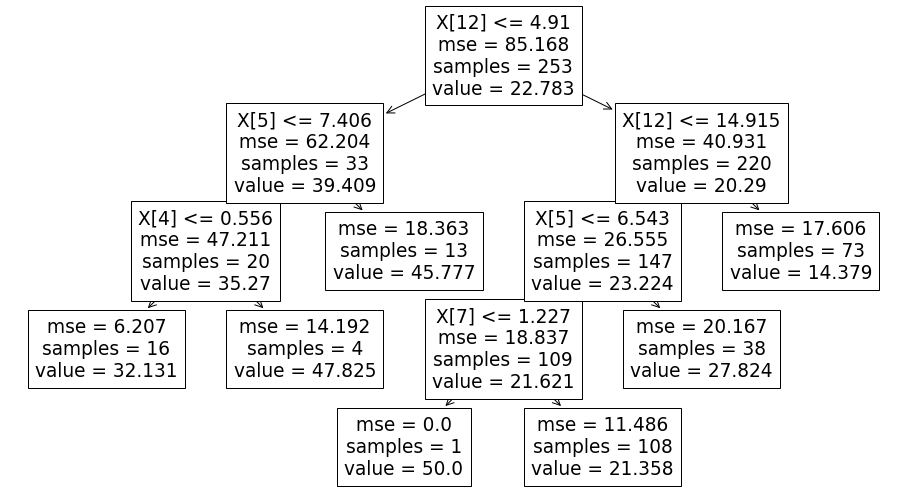

In [8]:
plt.figure(figsize=(16, 9))
tree.plot_tree(t)
plt.show()

In [36]:
mses = {}
y_pred = t.predict(X_test)
mses["tree"] = mse(y_pred, y_test)
mses["tree"]

21.86969097197515

In [37]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [43]:
bag = BaggingRegressor(n_jobs=-1).fit(X_train, y_train)
y_pred = bag.predict(X_test)
mses["bagging"] = mse(y_pred, y_test)
mses["bagging"]

16.028660079051384

In [44]:
rf = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
y_pred = rf.predict(X_test)
mses["random forest"] = mse(y_pred, y_test)
mses["random forest"]

12.877479213438736

In [110]:
gbm = lightgbm.LGBMRegressor().fit(X_train, y_train)
y_pred = gbm.predict(X_test)
mses["gradient boosting"] = mse(y_pred, y_test)
mses["gradient boosting"]

12.837924375148141

In [189]:
pd.Series(mses).round(3)

tree                 21.870
bagging              16.029
random forest        12.877
gradient boosting    12.838
dtype: float64

In [13]:
df = pd.read_csv("carseats.csv")

In [80]:
X_train.shape

(253, 13)

In [81]:
mtries = np.array([1, 4, 7, 10, 13])  # np.arange(1, 10)
ntrees = np.arange(10, 250, 30)

In [82]:
# mtry -> max_features
# - randomForest.mtry: Number of variables randomly sampled as candidates at each split.
#   Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p/3)
# - RandomForestRegressor.max_features: {"auto", "sqrt", "log2"}, int or float, default="auto"
#   The number of features to consider when looking for the best split:

# ntree -> n_estimators
# - randomForest.ntree: Number of trees to grow. This should not be set to too small a number,
#   to ensure that every input row gets predicted at least a few times.
# - RandomForestRegressor.n_estimators : The number of trees in the forest.

In [188]:
from itertools import product  # El producto cartesiano de dos conjuntos
list(product(["a", "b", "c"], [0, 1]))

[('a', 0), ('a', 1), ('b', 0), ('b', 1), ('c', 0), ('c', 1)]

In [84]:
forests = {}
results =  []
for mtry, ntree in product(mtries, ntrees):  # Equivalente a anidar dos for-loops sobre mtries y ntrees
    print(".", end="")
    forest = forests[mtry, ntree] = RandomForestRegressor(n_estimators=ntree, max_features=mtry).fit(X_train, y_train)
    results.append(
        {
            "n_estimators": ntree,
            "max_features": mtry,
            "train_mse": mse(y_train, forest.predict(X_train)),
            "test_mse": mse(y_test, forest.predict(X_test)),
        })

........................................

In [101]:
res = pd.DataFrame(results)
res.sort_values("test_mse").head()

,n_estimators,max_features,train_mse,test_mse
21,160,7,1.481334,11.222596
31,220,10,1.735743,11.288529
16,10,7,2.566445,11.308840
23,220,7,1.566287,11.552729
18,70,7,1.750962,11.719681


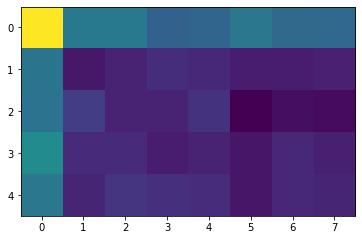

In [102]:
plt.imshow(res.pivot("max_features", "n_estimators", "train_mse"))
# res.pivot("max_features", "n_estimators", "train_mse")
# plt.legend()

In [103]:
# plt.imshow(res.pivot("max_features", "n_estimators", "test_mse"))
res.pivot("max_features", "n_estimators", "test_mse")
# plt.legend()

n_estimators,10,40,70,100,130,160,190,220
max_features,,,,,,,,
1,20.641302,17.439732,18.045706,18.671754,18.059485,17.171633,18.311205,17.040547
4,13.723257,12.100950,11.957028,12.059226,12.233489,12.350849,11.939191,12.144551
7,11.308840,12.030814,11.719681,12.147681,11.802961,11.222596,12.152122,11.552729
10,14.243051,11.785972,11.894020,12.659143,11.796680,12.024992,12.475126,11.288529
13,15.173250,13.438933,13.271273,13.131430,13.009428,11.936892,12.684069,12.387880


In [377]:
pd.Series(mses).round(2).sort_values()

gradient boosting    12.84
random forest        12.88
bagging              16.03
tree                 21.87
dtype: float64

<AxesSubplot:>

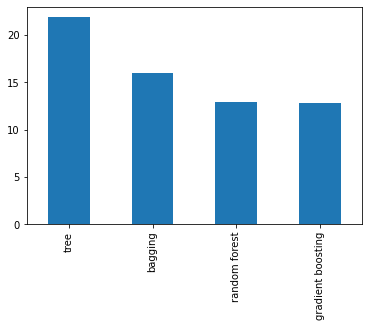

In [378]:
pd.Series(mses).round(2).plot(kind="bar")

# Ejercicio 2

*   Dataset: **Carseats**
*   *Sales* con valores continuos
*   Lab 8.3.1, página 353
*   Ejercicio 8.4.8, página 363

1. Separar los datos en conjuntos de train y test.
2. Modelar un árbol de regresión para el conjunto de training. Hacer un plot del árbol, calcular el error MSE en test e interpretar.
3. Aplicar cross-validation para determinar la cantidad óptima de nodos terminales del árbol.
4. Realizar un modelo *bagging* para el dataset, calcular el error MSE en test e interpretar. Usando la función *importance()* determinar las variables más importantes.
5. Realizar modelos *random forest* para el dataset, calcular el error MSE en test e interpretar. Usando la función *importance()* determinar las variables más importantes. 



In [104]:
cseats = pd.read_csv("carseats.csv")

In [130]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [144]:
cseats.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

In [145]:
X = cseats.drop(columns="Sales")
y = cseats.Sales

In [146]:
categorical_features = X.columns[X.dtypes == "O"].tolist()
X_cat, X_num = X[categorical_features], X.drop(columns=categorical_features)

In [156]:
ohe = OneHotEncoder(drop="first", sparse=False).fit(X_cat)

In [162]:
X = pd.concat(
    [
        pd.DataFrame(
            data=ohe.transform(X_cat).astype(int),
            columns=ohe.get_feature_names(categorical_features)
        ),
        X_num,
    ],
    axis=1,
)
X.head()

,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes,CompPrice,Income,Advertising,Population,Price,Age,Education
0,0,0,1,1,138,73,11,276,120,42,17
1,1,0,1,1,111,48,16,260,83,65,10
2,0,1,1,1,113,35,10,269,80,59,12
3,0,1,1,1,117,100,4,466,97,55,14
4,0,0,1,0,141,64,3,340,128,38,13


In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=X.shape[0] // 2)

In [164]:
X_train.shape

(200, 11)

In [311]:
max_leaves = np.arange(5, 200)
res = []
for l in max_leaves:
    print(".", end="")
    t = tree.DecisionTreeRegressor(max_leaf_nodes=l).fit(X_train, y_train)
    res.append(
        {
            "leaves": l,
            "train_mse": mse(y_train, t.predict(X_train)),
            "test_mse": mse(y_test, t.predict(X_test)),
        }
    )

...................................................................................................................................................................................................

In [312]:
res = pd.DataFrame(res)

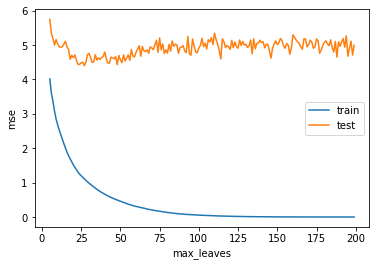

In [313]:
sns.lineplot(x="leaves", y="train_mse", data=res, label="train")
sns.lineplot(x="leaves", y="test_mse", data=res, label="test")
plt.xlabel("max_leaves"), plt.ylabel("mse"), plt.legend()
plt.show()

In [325]:
res[res.test_mse <= res.test_mse.min()]

,leaves,train_mse,test_mse
22,27,1.111449,4.398845


In [324]:
res[res.test_mse <= res.test_mse.min() * 1.01].sort_values("leaves").head(1)

,leaves,train_mse,test_mse
18,23,1.302603,4.43626


El mejor modelo por `test_mse` absoluto tiene 27 hojas, pero a menos de 1% de diferencia en `test_mse`, podemos encontrar árboles de 23 hojas. Este segundo es más "parsimonioso", pero con casi idéntica performance.
A conclusiones similares podríamos haber llegado controlando el alpha de costo de complejidad:

In [326]:
alphas = np.logspace(-5, 1, 400)
res = []
for alpha in alphas:
    print(".", end="")
    t = tree.DecisionTreeRegressor(ccp_alpha=alpha).fit(X_train, y_train)
    res.append(
        {
            "alpha": alpha,
            "leaves": t.get_n_leaves(),
            "train_mse": mse(y_train, t.predict(X_train)),
            "test_mse": mse(y_test, t.predict(X_test)),
        }
    )

................................................................................................................................................................................................................................................................................................................................................................................................................

In [327]:
res = pd.DataFrame(res)

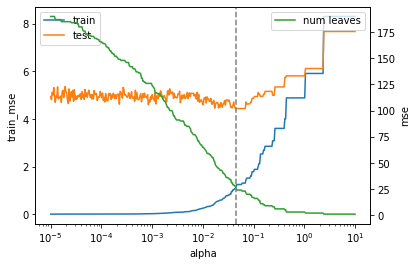

In [379]:
fig, ax1 = plt.subplots()
sns.lineplot(x="alpha", y="train_mse", data=res, label="train", ax=ax1, color="C0")
sns.lineplot(x="alpha", y="test_mse", data=res, label="test", ax=ax1, color="C1")
# Para tener dos escalas distintas en el mismo gráfico:
# https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/two_scales.html
ax2 = ax1.twinx()
sns.lineplot(x="alpha", y="leaves", data=res, label="num leaves", ax=ax2, color="C2")
best_alpha = res.iloc[np.argmin(res.test_mse.values)].alpha
plt.axvline(best_alpha, color="gray", linestyle="dashed")
plt.ylabel("mse"), plt.xscale("log"), plt.legend()
plt.show()

In [368]:
res[res.alpha == best_alpha]

,alpha,leaves,train_mse,test_mse
243,0.045096,26,1.153008,4.435875


In [369]:
res[res.test_mse <= res.test_mse.min() * 1.01].sort_values("leaves").head(1)

,alpha,leaves,train_mse,test_mse
255,0.068326,23,1.302603,4.43626


Con $\alpha = 0.045$ encontramos un áëbol de 26 hojas y el mejor ECM en `test`, y una vez más, a menos del 1% de diferencia en ECM, el mejor árbol "parsimonioso" de 23 hojas qu encontramos por CV sobre el número de hojas directamente.

In [136]:
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough",
)